# Sequence Based Recommendations Module

- This notebook aims to show how to use sequence-based-recommendation module created by Robin Devooght. Some of these functions have been utilized in recent papers provided by the authors tackling sequence-based recommender systems 

<par>All code can be accessed in https://github.com/rdevooght/sequence-based-recommendations but a few modifications have been made</par>

## Methods

The available methods are:
* [Recurrent Neural Networks](#recurrent-neural-networks)
* [Stacked Denoising Autoencoder](#stacked-denoising-autoencoders)
* [Latent Tarjectory Modeling/word2vec](#latent-trajectory-modeling)
* [BPR-MF](#bpr-mf)
* [FPMC](#fpmc)
* [FISM](#fism)
* [Fossil](#fossil)
* [Markov Chains](#markov-chain)
* [User KNN](#user-knn)
* [Popularity baseline](#pop)

### Neural Networks
#### Recurrent Neural Networks

Use it with `-m RNN`.
The RNN have many options allowing to change the type/size/number of layers, the training procedure and the objective function, and some options are specific to a particular objective function.

##### Layers

Option | Desciption
------ | ----------
`--r_t [LSTM, GRU, Vanilla]` | Type of recurrent layer (default is GRU)
`--r_l size_of_layer1-size_of_layer2-etc.` | Size and number of layers. for example, `--r_l 100-50-50` creates a layer with 50 hidden neurons on top of another layer with 50 hidden neurons on top of a layer with 100 hidden neurons. Default: 32.
`--r_bi` | Use bidirectional layers.
`--r_emb size` | Adds an embedding layer before the recurrent layer. By default no embedding layer is used, but it is adviced to use one (e.g. `--r_emb 100`).

##### Update mechanism

Option | Desciption
------ | ----------
`--u_m [adagrad, adadelta, rmsprop, nesterov, adam]` | Update mechanism (see [Lasagne doc](http://lasagne.readthedocs.io/en/latest/modules/updates.html)). Default is adam
`--u_l float` | Learning rate (default: 0.001). The default learning rate works well with adam. For adagrad `--u_l 0.1` is adviced.
`--u_rho float` | rho parameter for Adadelta and RMSProp, or momentum for Nesterov momentum (default: 0.9).
`--u_b1 float` | Beta 1 parameter for Adam (default: 0.9).
`--u_b2 float` | Beta 2 parameter for Adam (default: 0.999).

##### Noise

Option | Desciption
------ | ----------
`--n_dropout P` | Dropout probability (default: 0.)
`--n_shuf P` | Probability that an item is swapped with another one (default: 0.).
`--n_shuf_std STD` | If an item is swapped, the position of the other item is drawn from a normal distribution whose std is defined by this parameter (default: 5.).

##### Other options

Option | Desciption
------ | ----------
`-b int` | Size of the mini-batchs (default: 16)
`--max_length int` | Maximum length of sequences (default: 200)
`-g val` | Gradient clipping (default: 100)
`--repeated_interactions` | Use when a user can interact multiple times with the same item. If not set, the items that the user already saw are never recommended.

##### Objective functions

Option | Desciption
------ | ----------
`--loss [CCE, Blackout, TOP1, BPR, hinge, logit, logsig]` | Objective function. CCE is the categorical cross-entropy, BPR, TOP1 and Blackout are based on sampling, and hinge, logit and logsig allow to have multiple targets. Default is CCE.
`-r float` | *Only for CCE*. Add a regularization term. A positive value will use L2 regularization and a negative value will use L1. Default: 0.
`--db float` | *Only for CCE, Blackout, BPR and TOP1*. Increase the diversity bias to put more pressure on learning correct recomendations for unfrequent items (default: 0.).
`--sampling float or int` | *Only for Blackout, BPR and TOP1*. Number of items to sample in the error computation. Use a float in [0,1] to express it as a fraction of the number of items in the catalog, or an int > 0 to specify the number of samples directly. Default: 32.
`--n_targets N` | *Only for hinge, logit and logsig*. Number of items in the sequence that are used as targets. Default: 1.

##### Clustering

It is possible to combine RNNs with an item-clustering method. This leads to faster prediction on large dataset and creates meaningful item clusters.
In order to use it, use the option `--clusters nb_of_clusters`.  
For example, `python train.py -d path/to/dataset/ -m RNN --loss BPR --clusters 10` will train an RNN with the BPR loss and 10 clusters of items.
Note that the clustering is only compatible with sampling-based loss (BPR, Blackout and TOP1). 
It also works with `--loss CCE`, but a sampling version of CCE is then used instead of the normal categorical cross-entropy.
	

#### Stacked Denoising Autoencoders

Use it with `-m SDAE`.
SDAE the RNN options described in "[Update mechanism](#update-mechanism)" and "[Other options](#other-options)".

Option | Desciption
------ | ----------
`--L size_of_layer1-size_of_layer2-etc.` | Size and number of layers. for example, `--r_l 50-32-50` creates a layer with 50 hidden neurons on top of another layer with 32 hidden neurons on top of a layer with 50 hidden neurons. Default: 20.
`--in_do float` | Dropout rate applied to the input layer of the SDAE (default: 0.2).
`--do float` | Dropout rate applied to the hidden layers of the SDAE (default: 0.5).

#### Latent Trajectory Modeling

Use it with `-m  LTM`.
LTM is a method based on word2vec, described in "[Latent Trajectory Modeling: A Light and Efficient Way to Introduce Time in Recommender Systems](http://dl.acm.org/citation.cfm?id=2799676)".
LTM works in two steps: it first produces an embedding of the items with the word2vec algorithm using the sequence of items in the training set, then it estimates for each user a translation vector that would best explain the trajectory of that user in the embedded space.
Predictions are made by finding the closest items to the last user item translated by the user's translation vector.
Our implementation is mainly a wrapper around [Gensim's word2vec implementation](https://radimrehurek.com/gensim/models/word2vec.html).

Option | Desciption
------ | ----------
`-H int` | Number of neurons (default: 20).
`--ltm_window int` | Size of word2vec's window (default: 5).
`--ltm_damping float` | Temporal damping (default: 0.8).
`--ltm_no_trajectory` | Use this option to make predictions directly with word2vec, without the trajectory estimation proposed in the LTM paper.

### Factorization-based
#### FPMC

FPMC is a method combining factorized markov chains with the factorization of the user-item matrix (see "Factorizing personalized Markov chains for next-basket recommendation" by Rendle et al. in *Proceedings of WWW'10*).
Use it with `-m FPMC`

Option | Desciption
------ | ----------
`--k_cf int` | Rank of the user-item matrix factorization (default: 32).
`--k_mc int` | Rank of the factorized Markov chain (default: 32).
`-l val` | Learning rate (default: 0.01).
`--cooling val` | Multiplicative factor applied to the learning rate after each epoch (default: 1)
`--init_sigma val` | Standard deviation of the gaussian initialization (default: 1).
`--fpmc_bias val` | Sampling bias (default: 100). By default the SGD process uses adaptive sampling to speed up learning. This parameter is used to control how much the sampling is biased towards high error items.
`--no_adaptive_sampling` | No adaptive sampling
`-r float` | Add a regularization term. A positive value will use L2 regularization and a negative value will use L1. Default: 0.

#### BPR-MF

BPR-MF is a matrix factorization method based on the BPR loss (see "BPR: Bayesian personalized ranking from implicit feedback" by Rendle et al. in *Proceedings of the twenty-fifth conference on uncertainty in artificial intelligence*)
Use it with `-m BPRMF`

Option | Desciption
------ | ----------
`-H int` | Rank of the user-item matrix factorization (default: 20).
`-l val` | Learning rate (default: 0.01).
`--cooling val` | Multiplicative factor applied to the learning rate after each epoch (default: 1)
`--init_sigma val` | Standard deviation of the gaussian initialization (default: 1).
`--fpmc_bias val` | Sampling bias (default: 100). By default the SGD process uses adaptive sampling to speed up learning. This parameter is used to control how much the sampling is biased towards high error items.
`--no_adaptive_sampling` | No adaptive sampling
`-r float` | Add a regularization term. A positive value will use L2 regularization and a negative value will use L1. Default: 0.

#### FISM

FISM is a method based of item-item factorization (see "Fism: factored item similarity models for top-n recommender systems" by Kabbur et al. in *Proceedings of SIGKDD'13*).
It has the advantage over BPR-MF that it does not build a representation for each user. This leads to smaller models, and the ability to make recommendation to new users.
Use it with `-m FISM --loss [BPR, RMSE]`

Option | Desciption
------ | ----------
`--loss [BPR, RMSE]` | Loss function. "BPR" is the same loss as for BPR-MF, "RMSE" optimizes the square error. This cannot be left to default because the default loss is CCE, which is not compatible with FISM.
`-H int` | Rank of the matrix factorization (default: 20).
`--fism_alpha float` | Alpha parameter in FISM. (default: 0.2).
`-l val` | Learning rate (default: 0.01).
`--cooling val` | Multiplicative factor applied to the learning rate after each epoch (default: 1)
`--init_sigma val` | Standard deviation of the gaussian initialization (default: 1).
`-r float` | Add a regularization term. A positive value will use L2 regularization and a negative value will use L1. Default: 0.

FISM can be combined with item-clustering the same way that RNN can.
To do so, add the option `--clusters nb_of_clusters`.
When using clustering, a completely different implementation is used, which is based on Theano instead of Numpy.
This has some implications on the available options:
* The loss must be choosen among CCE, BPR, Blackout and TOP1 instead of BPR and RMSE.
* The number of samples for each training step can be specified using `--sampling nb_of_samples`.
* The update mechanism is controled by the options defined in [Update mechanism](#update-mechanism) instead of `-l` and `--cooling`.

#### Fossil

Fossil combines FISM with factorized markov chains (see "Fusing Similarity Models with Markov Chains for Sparse Sequential Recommendation" by He and McAuley in *Proceedings of ICDM'16*).
Unlike FPMC, Fossil can use higher-order markov chains.
Use it with `-m Fossil`

Option | Desciption
------ | ----------
`-H int` | Rank of the matrix factorization (default: 20).
`--fism_alpha float` | Alpha parameter in FISM. (default: 0.2).
`--fossil_order int` | Order of the markov chains in Fossil. (default: 1).
`-l val` | Learning rate (default: 0.01).
`--cooling val` | Multiplicative factor applied to the learning rate after each epoch (default: 1)
`--init_sigma val` | Standard deviation of the gaussian initialization (default: 1).
`-r float` | Add a regularization term. A positive value will use L2 regularization and a negative value will use L1. Default: 0.

### Lazy

**Lazy methods do not build models**, they make recommendation directly based on the dataset.
They should therefore not be used with `train.py`, but only with `test.py`.

#### POP

Use it with `-m POP`.
Always predict the most popular items.

#### Markov Chain

Use it with `-m MM`.
Recommends the items that follow most often the last item the user's sequence.

#### User KNN

Use it with `-m UKNN`.
User-based nearest neighbors approach. 
The similarity measure between users is the cosine similarity: #number-of-common-items / sqrt(#number-of-items-of-user-a * #number-of-items-of-user-b).

Option | Desciption
------ | ----------
`--ns int` | Neighborhood size (default: 80).
	

In [2]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import joblib
import os.path
import sys
sources_path = './../Sources'
sys.path.append('./../Sources/Devooght/')
if sources_path not in sys.path:
    sys.path.append(sources_path)

#from Evaluations.metrics import MSE, RMSE, MAE
import os
#sys.path.append('../Sources') # Adding my own libs source
#from StackedAutoEncoderRS.SAERS import SAE

In [3]:
%matplotlib inline
results_path = './Results/'
verbose = True

_________________
## Loading Dataset

In [4]:
%%time

dataset = '100k/' #100k dataset path
#dataset = '10M/' #10M dataset path
#dataset = '20M/' #20M dataset path

dataset_path = '../../Datasets/movieLens/' + dataset; # Full dataset path

filenames = {'movie': 'movie.csv', 'rating': 'rating.csv'}

#df_ratings = preprocess.load_data(filename = dataset_path+filenames['rating'], 
#                       columns = ['userId', 'itemId', 'rating', 'timestamp'], 
#                       separator = ',',
#                        verbose = True)


CPU times: user 7 µs, sys: 4 µs, total: 11 µs
Wall time: 11.9 µs


___________________

## Preprocessing

This script (preprocess.py) takes a file containing a dataset of user/item interactions and split it into training/validation/test sets and save them in the format used by train.py and test.py.
The original dataset must be in a format where each line correspond to a single user/item interaction.

The only required argument is `-f path/to/dataset`, which is used to specify the original dataset. The script will create subfolders named "data", "models" and "results" in the folder containing the original dataset. "data" is used by preprocess.py to store all the files it produces, "models" is used by train.py to store the trained models and "results" is used by test.py to store the results of the tests.

The optional arguments are the following:

Option | Desciption
------ | ----------
`--columns` | Order of the columns in the file (eg: "uirt"), u for user, i for item, t for timestamp, r for rating. If r is not present a default rating of 1 is given to all interaction. If t is not present interactions are assumed to be in chronological order. Extra columns are ignored. Default: uit
`--sep` | Separator between the column. If unspecified pandas will try to guess the separator
`--min_user_activity` | Users with less interactions than this will be removed from the dataset. Default: 2
`--min_item_pop` | Items with less interactions than this will be removed from the dataset. Default: 5
`--val_size` | Number of users to put in the validation set. If in (0,1) it will be interpreted as the fraction of total number of users. Default: 0.1
`--test_size` | Number of users to put in the test set. If in (0,1) it will be interpreted as the fraction of total number of users. Default: 0.1
`--seed` | Seed for the random train/val/test split

In [5]:
import Devooght.preprocess as preprocess
reload(preprocess)
# Arguments
directory_path = os.path.join('.', 'Sequence_based_recommendation_files')

* Creating Auxiliary Directories

In [6]:
%%time

# Creating Directory path
directory_path = os.path.join('.', 'Sequence_based_recommendation_files')

preprocess.create_dirs(dirname=directory_path, verbose = verbose)

data = preprocess.load_data(
                filename = dataset_path+filenames['rating'], 
                columns = ['userId', 'itemId', 'rating', 'timestamp'], 
                separator = ',',
                sort_time = False,
                verbose = verbose)    

data = preprocess.remove_rare_elements(
                data = data, 
                min_user_activity = 1, 
                min_item_popularity = 1,
                verbose = verbose)


[*] Creating directories in ./Sequence_based_recommendation_files
[ ] Creating data directory
[ ] Creating models directory
[ ] Creating results directory
[+] Directories created.
[*] Loading data from ../../Datasets/movieLens/100k/rating.csv...
[ ] Sorting timestamp column
[+] Data Loaded
   userId  itemId  rating           timestamp
0     196     242       3 1997-12-04 15:55:49
1     186     302       3 1998-04-04 19:22:22
2      22     377       1 1997-11-07 07:18:36
3     244      51       2 1997-11-27 05:02:03
4     166     346       1 1998-02-02 05:33:16
[*] Removing inactive users and rare items...
[+] Rare users and items removed.
CPU times: user 82 ms, sys: 9.25 ms, total: 91.2 ms
Wall time: 91.7 ms


In [7]:
print (data.shape)
data.head()

(100000, 4)


,userId,itemId,rating,timestamp
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16


Save the mapping of original user and item ids to numerical consecutive ids in dirname.
NB: some users and items might have been removed in previous steps and will therefore not appear in the mapping.
    

In [8]:
data = preprocess.save_index_mapping(data = data, 
                                     dirname = directory_path, 
                                     separator = ',')
data.head()

,userId,itemId,rating,timestamp,u_original,i_original
0,195,241,3,1997-12-04 15:55:49,196,242
1,185,301,3,1998-04-04 19:22:22,186,302
2,21,376,1,1997-11-07 07:18:36,22,377
3,243,50,2,1997-11-27 05:02:03,244,51
4,165,345,1,1998-02-02 05:33:16,166,346


Splits the data set into training, validation and test sets.
Each user is in one and only one set.
nb_val_users is the number of users to put in the validation set.
nb_test_users is the number of users to put in the test set.

In [9]:
train_set, val_set, test_set = preprocess.split_data(
    data = data, 
    nb_val_users = 0.1, # val_size
    nb_test_users = 0.1, # test_size
    dirname = directory_path,
    verbose = verbose)
print (train_set.shape)
train_set.head()

[*] Splitting data into training, validation and test sets
[ ] Saving training, validation and test sets in the triplets format
[+] Split data saved on ./Sequence_based_recommendation_files/data folder.
(80847, 6)


,userId,itemId,rating,timestamp,u_original,i_original
0,195,241,3,1997-12-04 15:55:49,196,242
2,21,376,1,1997-11-07 07:18:36,22,377
3,243,50,2,1997-11-27 05:02:03,244,51
4,165,345,1,1998-02-02 05:33:16,166,346
6,114,264,2,1997-12-03 17:51:28,115,265


Convert the train/validation/test sets in the sequence format and save them.
Also create the extended training sequences, which countains the first half of the sequences of users in the validation and test sets

In [10]:
%%time
preprocess.make_sequence_format(
    train_set = train_set, 
    val_set = val_set, 
    test_set = test_set, 
    dirname = directory_path,
    verbose = verbose)

[*] Making sequence format
[ ] Saving training set in the sequences format...
[ ] Saving validation set in the sequences format...
[ ] Saving test set in the sequences format...
[ ] Saving the extended training set in the sequences format...
[+] Sequence format saved on ./Sequence_based_recommendation_files/data folder
CPU times: user 357 ms, sys: 8.3 ms, total: 365 ms
Wall time: 400 ms


Saving data stats

In [11]:
preprocess.save_data_stats(
                data = data, 
                train_set = train_set, 
                val_set = val_set, 
                test_set = test_set, 
                dirname = directory_path,
                verbose = verbose)

[*] Saving stats to ./Sequence_based_recommendation_files/data/stats file
[+] Stats saved.


In [12]:
df_stats = preprocess.get_data_stats(dirname = directory_path, verbose = verbose)
df_stats.head()

[*] Getting data stats from ./Sequence_based_recommendation_files/data/stats file.
[+] Data stats returned


,set,n_users,n_items,n_interactions,longest_sequence
0,Full,943,1682,100000,737
1,Train,762,1648,80847,737
2,Val,89,1345,10457,540
3,Test,92,1135,8696,414


Making Readme file

In [13]:
preprocess.make_readme(dirname = directory_path, 
                       val_set = val_set, 
                       test_set = test_set)

The following files were automatically generated by preprocess.py

    user_id_mapping
		mapping between the users ids in the original dataset and the new users ids.
		the first column contains the new id and the second the original id.
        Inactive users might have been deleted from the original, and they will therefore not appear in the id mapping.

	item_id_mapping
		Idem for item ids.

	train_set_triplets
		Training set in the triplets format.
		Each line is a user item interaction in the form (user_id, item_id, rating). 
		Interactions are listed in chronological order.

	train_set_sequences
		Training set in the sequence format.
		Each line contains all the interactions of a user in the form (user_id, first_item_id, first_rating, 2nd_item_id, 2nd_rating, ...).

	train_set_sequences+
		Extended training set in the sequence format.
		The extended training set contains all the training set plus the first half of the interactions of each users in the validation and testing set.

	val_set_triplets
		Validation set in the triplets format

	val_set_triplets
		Validation set in the sequence format

	test_set_triplets
		Test set in the triplets format

	test_set_triplets
		Test set in the sequence format

	stats
		Contains some informations about the dataset.

_________________________

## Train

This script is used to train models and offers many options regarding when to save new models and when to stop training.

If you have multiple datasets with a partly common path (e.g. path/to/dataset1/, path/to/dataset2/, etc.) you can specify this common path in the variable DEFAULT_DIR of helpers/data_handling.py. For example, setting DEFAULT_DIR = "path/to/" and using the argument `-d dataset1` will look for the dataset in "path/to/dataset1/".

The optional arguments are the following:

Option | Desciption
------ | ----------
`--dir dirname/` | Name of the subfolder of "path/to/dataset/models/" in which to save the model. By default it will be saved directly in the models/ folder, but using subfolders can be useful when many models are tested.
`--progress {int or float}` | Number of iterations (or seconds) between two evaluations of the model on the validation set. When the model is evaluated, progress is shown on the command line, and the model might be saved (depending on the `--save` option). An float value means that the evaluations happen at geometric intervals (rather than linear). Default: 2.0
`--metrics value` | Metrics computed on the validation set, separated by commas. Available metrics are recall, sps, ndcg, item\_coverage, user\_coverage and blockbuster\_share. Default: sps.
`--save [All, Best, None]` | Policy for saving models. If "None", no model is saved. If "All", the current model is saved each time the model is evaluated on the validation set, and no model is destroyed. If "Best", the current model is only saved if it improves over the previous best results on the validation set, and the previous best model is deleted. If "Best" and multiple metrics are used, all the pareto-optimal models are saved. 
`--time_based_progress` | Base the interval between two evaluations on the number of elapsed seconds rather than on the number of iterations.
`--mpi value` | Max number of iterations (or seconds) between two evaluations (useful when using geometric intervals). Default: inf.
`--max_iter value` | Max number of iterations (default: inf).
`--max_time value` | Max training time in seconds (default: inf).
`--min_iter value` | Min number of iterations before making the first evaluation (default: 0).
`--extended_set` | Use extended training set (contains first half of validation and test set). This is necessary for factorization based methods such as BPRMF and FPMC because they need to build a model for every user.
`--tshuffle` | Shuffle the order of sequences between epochs.
`--load_last_model` | Load Last model before starting training (it will search for a model build with all the same options and take the one with the largest number of epochs).
`--es_m [WorstTimesX, StopAfterN, None]` | Early stopping method (by default none is used, and training continues until max_iter or max_time is reached). WorstTimesX will stop training if the number of iterations since the last best score on the validation set is longer than X times the longest time between two consecutive best scores. StopAfterN will stop the training if the model has not improved for the N last evaluations on the validation set.
`--es_n N` | N parameter for StopAfterN (default: 5).
`--es_x X` | X parameter for WorstTimesX (default: 2).
`--es_min_wait num_epochs` | Mininum number of epochs before stopping (for WorstTimesX). Default: 1.
`--es_LiB` | Lower is better for validation score. By default a higher validation score is considered better, but if it is not the case you can use this option.

The options specific to each method are explained in the Methods section.

In [14]:
import Devooght.train as train
reload(train)

<module 'Devooght.train' from './../Sources/Devooght/train.pyc'>

command_parser: a parser containing sub command parsers such as parser to predictor, training and early stopping

sub_command_parser should be callables that will add arguments to the command parser

4 sub commands parser are used:
- **predictor_command_parser** from the helpers.command_parser module
- **training_command_parser** from the train module
- **early_stopping_command_parser** from the helpers.command_parser module
- **test_command_parser** from the test module

All commands are orchestraded by **command_parser** from the helpers.command_parser module
	

In [74]:
import Devooght.train as train
reload(train)
import helpers.command_parser as parse
reload(parse)
parser = parse.command_parser(parse.predictor_command_parser, 
                            train.training_command_parser, 
                            parse.early_stopping_command_parser
)

In [76]:
args = parser.parse_args(['--dir', os.path.join(directory_path, 'models'), #directory_path + '/models/', 
                          '-d', directory_path, #directory_path + '/', 
                          '-b', '20', # Batch size: the number of training examples present in a single blatch
                          '--max_iter', '50', # Maximum number of iterations: the number of batches needed to complete one epoch
                          '--progress', '10', # when progress information should be printed during training
                          '-m', 'FISM', # Method
                          #'-i', '-1', # Number of batches - only on test parser
                         '--loss', 'RMSE',
                         '--save', 'Best']) 


In [66]:
args

Namespace(balance=1.0, batch_size=20, c_sampling=-1, cluster_type='mix', clusters=-1, cooling=1.0, csn=0.0, dataset='./Sequence_based_recommendation_files', dir='./Sequence_based_recommendation_files/models', diversity_bias=0.0, dropout=0.5, early_stopping_method='None', es_LiB=False, es_min_wait=1.0, es_n=5, es_x=2.0, extended_set=False, fism_alpha=0.2, fossil_order=1, fpmc_bias=100.0, gradient_clipping=100, hidden=20, ignore_clusters=False, init_scale=1.0, init_sigma=1, input_dropout=0.2, k_cf=32, k_mc=32, layers='20', learning_rate=0.01, load_last_model=False, loss='RMSE', ltm_damping=0.8, ltm_no_trajectory=False, ltm_window=5, max_iter=50.0, max_length=30, max_scale=50, max_time=inf, method='FISM', metrics='sps', mf=False, min_access=0.05, min_iter=0.0, mpi=inf, n_dropout=0.0, n_ratings=0.0, n_shuf=0.0, n_shuf_std=5.0, n_swap=0.0, n_targets=1, no_adaptive_sampling=False, ns=80, pb=False, progress='10', r_bi=False, r_emb=0, r_l='50', rand_test_target=False, recurrent_layer_type='GRU

In [50]:
predictor = parse.get_predictor(args)
predictor

In [67]:
from helpers import data_handling as handler
reload(handler)
dataset = handler.DataHandler(dirname = args.dataset, 
                      extended_training_set = args.extended_set, 
                      shuffle_training = args.tshuffle)

In [68]:
# MUST be called before train, load or top_k_recommendations
predictor.prepare_model(dataset)
metrics = predictor.train(dataset, 
        save_dir = args.dir, 
        time_based_progress = args.time_based_progress, 
        progress = float(args.progress), 
        autosave = args.save, 
        max_progress_interval = args.mpi, 
        max_iter = args.max_iter,
        min_iterations = args.min_iter,
        max_time = args.max_time,
        early_stopping = parse.get_early_stopper(args),
        load_last_model = args.load_last_model,
        validation_metrics = args.metrics.split(','))

RMSE SGD delta:  4.70215235375
RMSE SGD delta:  1.77813702403
RMSE SGD delta:  12.6005451033
RMSE SGD delta:  -20.0274075783
RMSE SGD delta:  -3.72515675732
RMSE SGD delta:  -0.706728653004
RMSE SGD delta:  -6.79756517432
RMSE SGD delta:  -2.11483135668
RMSE SGD delta:  -5.12091222695
RMSE SGD delta:  17.7864135435
Opening file (1)
Algorithm: FISM 
Batch Number: 10 
Epochs: 0.000123690427598 in 0.0501880645752 s
Last train cost : -0.162535372202
recall :  0.00671670435069
sps :  0.0
Best validation  sps :  0.0
blockbuster_share :  0.0294117647059
item_coverage :  31
ndcg :  0.0390445407843
user_coverage :  0.269662921348
-----------------
Saving model in ./Sequence_based_recommendation_files/models/fism_RMSE_ne0.0_lr0.01_an1.0_k20_reg0.0_ini1.npz


10 0.000123690427598 0.0535559654236 -0.162535372202 0.00671670435069 0.0 0.0294117647059 31 0.0390445407843 0.269662921348


RMSE SGD delta:  -32.9028299541
RMSE SGD delta:  19.4292130695
RMSE SGD delta:  -15.4982582781
RMSE SGD delta:  -0.418829649691
RMSE SGD delta:  -13.8530214828
RMSE SGD delta:  -0.321821660423
RMSE SGD delta:  7.05708055755
RMSE SGD delta:  1.54004610273
RMSE SGD delta:  -4.52261588353
RMSE SGD delta:  18.2536991331
RMSE SGD delta:  -8.63798135481
RMSE SGD delta:  -26.2823607796
RMSE SGD delta:  -31.4360623713
RMSE SGD delta:  23.773928755
RMSE SGD delta:  -11.8565637945
RMSE SGD delta:  -14.4984219717
RMSE SGD delta:  -0.963188754786
RMSE SGD delta:  -16.9735085421
RMSE SGD delta:  -6.68897281463
RMSE SGD delta:  22.6306655575
RMSE SGD delta:  -3.54277578693
RMSE SGD delta:  13.2512516981
RMSE SGD delta:  7.84218346511
RMSE SGD delta:  5.09788807733
RMSE SGD delta:  -6.0555367707
RMSE SGD delta:  2.84887512432
RMSE SGD delta:  -9.5523142516
RMSE SGD delta:  -5.20764794714
RMSE SGD delta:  0.50467440892
RMSE SGD delta:  -29.6741030048
RMSE SGD delta:  -18.6678559085
RMSE SGD delta:  -3

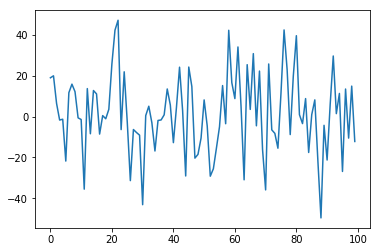

In [27]:
plt.plot(predictor.get_train_costs())

In [ ]:
user_items, true_item, false_item = predictor.get_auc_training_sample()
#rmse_training_sample = predictor.get_rmse_training_sample()
#predictor.item_score(user_items=)
print (user_items)
print (true_item)
print (predictor.item_score(user_items=user_items, item = true_item))
#print (false_item)
user_items, true_item, false_item = predictor.get_rmse_training_sample()
print (user_items)
print (true_item)
print (predictor.item_score(user_items=user_items, item = true_item))
#print (false_item)

In [ ]:
top_k_recommendations(sequence = user_items, user_id=None, k=10, exclude=None)

In [ ]:
metrics[0]

In [28]:
print ("Metrics: {}".format(metrics[0]))
print ("Time: {}".format(metrics[1]))
print ("Best filename: {}".format(metrics[2]))

Metrics: {'recall': 0.004756021892359606, 'sps': 0.011235955056179775, 'blockbuster_share': 0.03333333333333333, 'item_coverage': 26, 'ndcg': 0.033186774112860633, 'user_coverage': 0.21348314606741572}
Time: 0.263276100159
Best filename: ./Sequence_based_recommendation_files/models/fism_RMSE_ne0.0_lr0.01_an1.0_k20_reg0.0_ini1.npz


In [ ]:
predictor.get_auc_training_sample()

In [ ]:
#from factorization.fism import FISM
import factorization as fact
reload(fact)
#from neural_networks.fism_cluster import FISMCluster
import neural_networks as nn
reload(nn)

if args.clusters > 0:
    predictor = nn.fism_cluster.FISMCluster(h = args.hidden, 
                       reg = args.regularization, 
                       alpha = args.fism_alpha, 
                       loss = args.loss, 
                       interactions_are_unique = (not args.repeated_interactions), 
                       predict_with_clusters = (not args.ignore_clusters), 
                       sampling_bias = args.sampling_bias, 
                       sampling = args.sampling,  
                       cluster_sampling = args.c_sampling, 
                       init_scale = args.init_scale, 
                       scale_growing_rate = args.scale_growing_rate, 
                       max_scale = args.max_scale, 
                       n_clusters = args.clusters, 
                       cluster_type = args.cluster_type, 
                       updater = updater, 
                       target_selection = target_selection, 
                       sequence_noise = sequence_noise, 
                       recurrent_layer = recurrent_layer, 
                       use_ratings_features = args.rf, 
                       use_movies_features = args.mf, 
                       use_users_features = args.uf, 
                       batch_size=args.batch_size)
else:
    predictor = fact.fism.FISM(k=args.hidden, 
                   reg = args.regularization, 
                   learning_rate = args.learning_rate, 
                   annealing=args.cooling, 
                   init_sigma = args.init_sigma, 
                   loss=args.loss, 
                   alpha=args.fism_alpha)



In [ ]:
predictor.prepare_model(dataset)

metrics = predictor.train(dataset, 
        save_dir = args.dir, 
        time_based_progress = args.time_based_progress, 
        progress = float(args.progress), 
        autosave = args.save, 
        max_progress_interval = args.mpi, 
        max_iter = args.max_iter,
        min_iterations = args.min_iter,
        max_time = args.max_time,
        early_stopping = parse.get_early_stopper(args),
        load_last_model = args.load_last_model,
        validation_metrics = args.metrics.split(','))

## Test
This script test the models built with train.py on the test set.
The basic usage is:
````
python test.py -d path/to/dataset/ -m Method_name
````
The argument `-d` works in the same way as with train.py, and the precise model to test is specified by the `--dir` option and the methods-specific options.
If multiple models fit the options (They are in the same subfolder and were trained with the same method and same options), they are all evaluated one after the other, except if the argument `-i epoch_number` is also specified, which will then select the model based on the number of epochs.

`--metrics` allows to specify the list of metrics to compute, separated by commas. By default the metrics are: sps, recall, item\_coverage, user\_coverage, blockbuster_share.
The "blockbuster share" is the percentage of correct recommendations among the 1% most popular items.
The other available metrics are the sps, the ndcg and the assr (when clustering is used).

All the metrics are computed "@k", with k=10 by default. k can be changed using the `-k` option.

When the `--save` option is used, the results are saved in a file in "path/to/dataset/results/".
the results of each model form a line of the file, and each line contains the number of epochs followed by the metrics specified by `--metrics`.

When testing a method based on clustering, the option `--ignore_clusters` can be used to test how the method performs without clusters.

In [94]:
import Devooght.test as test
reload(test)

<module 'Devooght.test' from './../Sources/Devooght/test.py'>

In [83]:
parser = parse.command_parser(parse.predictor_command_parser, 
                            test.test_command_parser)

In [88]:
args = parser.parse_args(['--dir', os.path.join(directory_path, 'models'), #directory_path + '/models/', 
                          '-d', directory_path, #directory_path + '/', 
                          '-b', '20', # Batch size: the number of training examples present in a single blatch                                                    
                          '-m', 'FISM', # Method
                          '-i', '-1', # Number of batches - only on test parser
                         '--loss', 'RMSE']) 

In [96]:
import re
os.path.join(args.dir, re.sub('_ml'+str(args.max_length), '_ml'+str(args.training_max_length), predictor._get_model_filename(args.number_of_batches)))

'./Sequence_based_recommendation_files/models/fism_RMSE_ne*_lr0.01_an1.0_k20_reg0.0_ini1.npz'

In [97]:
args.training_max_length = args.max_length
# args.max_length = int(DATA_HANDLER.max_length/2)

print ("Number of batches: ", args.number_of_batches)
if args.number_of_batches == -1:
    args.number_of_batches = "*"
    
#dataset = handler.DataHandler(dirname=args.dataset)

#predictor = parse.get_predictor(args)

#predictor.prepare_model(dataset)

test_file = test.find_models(predictor, dataset, args)
print (test_file)

if args.number_of_batches == "*" and args.method != "UKNN" and args.method != "MM" and args.method != "POP":
    
    output_file = test.save_file_name(predictor, dataset, args)

    print ("output_file {}".format(output_file))
    
    last_tested_batch = test.get_last_tested_batch(output_file)
    batches = np.array(map(test.extract_number_of_epochs, test_file))
    sorted_ids = np.argsort(batches)
    batches = batches[sorted_ids]
    test_file = test_file[sorted_ids]
    
    print ("test_file", test_file)
    
    for i, f in enumerate(test_file):
        if batches[i] > last_tested_batch:
            evaluator = test.run_tests(predictor, f, dataset, args, get_full_recommendation_list=args.save_rank, k=args.nb_of_predictions)
            print('-------------------')
            print('({}/{}) results on {}'.format(i+1, len(file), f))            
            test.print_results(evaluator, args.metrics.split(','), plot=False, file=output_file, n_batches=batches[i], print_full_rank_comparison=args.save_rank)
else:
    
    evaluator = run_tests(predictor, file, dataset, args, get_full_recommendation_list=args.save_rank, k=args.nb_of_predictions)
    print_results(evaluator, args.metrics.split(','), file=save_file_name(predictor, dataset, args), print_full_rank_comparison=args.save_rank)

('Number of batches: ', '*')
[ './Sequence_based_recommendation_files/models/./Sequence_based_recommendation_files/models/fism_RMSE_ne0.002_lr0.01_an1.0_k20_reg0.0_ini1.npz'
 './Sequence_based_recommendation_files/models/./Sequence_based_recommendation_files/models/fism_RMSE_ne0.0_lr0.01_an1.0_k20_reg0.0_ini1.npz'
 './Sequence_based_recommendation_files/models/./Sequence_based_recommendation_files/models/fism_RMSE_ne0.001_lr0.01_an1.0_k20_reg0.0_ini1.npz']
output_file None
('test_file', array([ './Sequence_based_recommendation_files/models/./Sequence_based_recommendation_files/models/fism_RMSE_ne0.0_lr0.01_an1.0_k20_reg0.0_ini1.npz',
       './Sequence_based_recommendation_files/models/./Sequence_based_recommendation_files/models/fism_RMSE_ne0.001_lr0.01_an1.0_k20_reg0.0_ini1.npz',
       './Sequence_based_recommendation_files/models/./Sequence_based_recommendation_files/models/fism_RMSE_ne0.002_lr0.01_an1.0_k20_reg0.0_ini1.npz'],
      dtype='|S140'))
Opening file (1)


IndexError: index 1443 is out of bounds for axis 0 with size 1349

In [90]:
args.save

False

## Parser Tutorial

In [ ]:
import argparse

# Creating a parser
parser = argparse.ArgumentParser(description='Process some integers.')

# Adding arguments
parser.add_argument('integers', metavar='N', type=int, nargs='+', help='an integer for the accumulator')
parser.add_argument('--sum', dest='accumulate', action='store_const',
                     const=sum, default=max,
                     help='sum the integers (default: find the max)')
parser.add_argument('--max', dest='accumulate', action='store_const',
                     const=max, default=max,
                     help='max the integers (default: find the max)')

# Parsing arguments
#parser.parse_args()
parser.parse_args(['--sum', '7', '42'])
parser.parse_args(['--max', '5', '4'])
parser.epilog
#parser.argument_default